In [1]:
#import numpy as np
from pickle import load
from votekit.utils import mentions
#from tqdm import tqdm
#import matplotlib.pyplot as plt
#import random
from src.viz import viz_partition
from src.markov import gen_mentions_partition, random_partition, fast_tilted_run, fast_short_burst, calibrate_scores, short_burst, forward_convert, backward_convert
from src.scores import cut_score, relative_size_score, proportional_successive_matrix, cut_score_generator, relative_size_score_generator, first_second_score
from src.cleaning import Portland_clean, clean_and_make_boost, Scotland_clean
from src.clustering import create_graph_louvain_bm, louvain_partition_from_graph
#from functools import partial


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


## Data Loading
We pre-cleaned a profile for this notebook to execute fast, but this pickle was generated by functions available in the "src/loading.py" script.

In [2]:
with open('./data/Portland_D1.pkl', 'rb') as file:
    loaded = load(file)
boost = loaded['boost']
profile = loaded['profile']
#profile, boost = clean_and_make_boost(loaded['profile']) 
candidates = list(profile.candidates) #note: we call this the canonical ordering of candidates. It is important for viz + conversion tools.
print(candidates)

['Michael (Mike) Sands', 'Timur Ender', 'Deian Salazar', 'Loretta Smith', 'Steph Routh', 'David Linn', 'Candace Avalos', 'Jamie Dunphy', 'Peggy Sue Owens', 'Noah Ernst', 'Terrence Hayes', 'Thomas Shervey', 'Joe Allen', 'Joe Furi', 'Cayle Tern', 'Doug Clove']


## Visualization

A "partition" is a list of lists of strings, representing a way of partitioning the candidates into slates.

When executing fast chains, we turn this list of lists into a numpy int8 array, where the indices correspond to individual candidates, and the entries correspond to the slate that candidate is sorted into.

The "src/markov.py" has conversion functions to go between these two data types, but most of our API is built to accept input in either format.

The "src/viz.py" has a vizualization function, and "src/markov.py" has some initial partition generators.

List of lists format: [['Peggy Sue Owens', 'Jamie Dunphy', 'Joe Allen', 'Loretta Smith', 'Deian Salazar', 'Steph Routh'], ['Joe Furi', 'Timur Ender', 'Michael (Mike) Sands', 'Thomas Shervey', 'Candace Avalos'], ['Doug Clove', 'David Linn', 'Cayle Tern', 'Noah Ernst', 'Terrence Hayes']]
Numpy int32 array format: [1 1 0 0 0 2 1 0 0 2 2 1 0 1 2 2]
A random partition we generated:


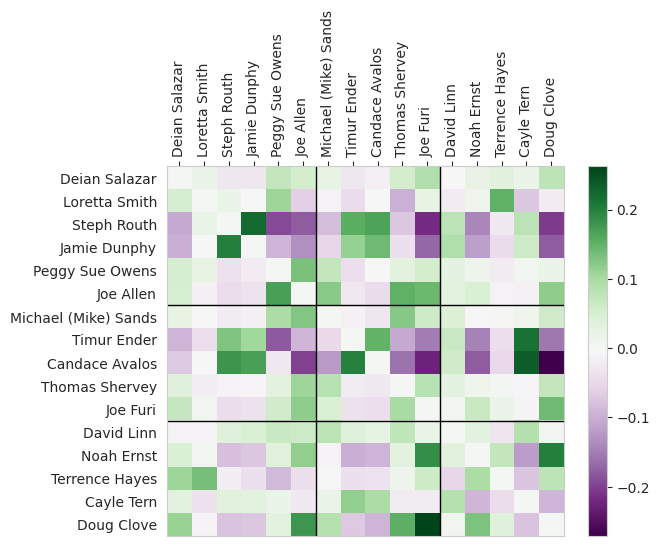

A partition with the candidates sorted by most to least mentions:


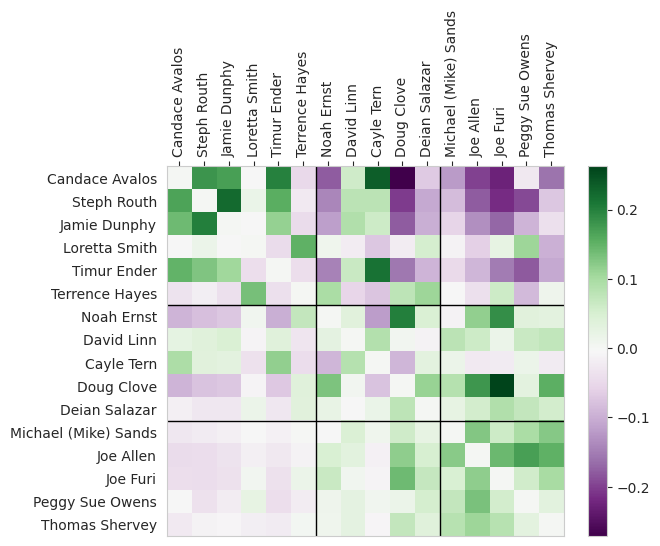

In [3]:
starting_partition = random_partition(candidates, 3)
print(f"List of lists format: {starting_partition}")
converted_partition = forward_convert(starting_partition, profile.candidates)
print(f"Numpy int32 array format: {converted_partition}")
mentions_partition = gen_mentions_partition(profile, candidates, 3)
print("A random partition we generated:")
viz_partition(converted_partition, boost, candidates) #note we passed the converted partition here
print("A partition with the candidates sorted by most to least mentions:")
viz_partition(mentions_partition, boost, candidates)

We can also use these tools to visualize other types of matrices. Below is a "proportional successive matrix"; the (i,j)th entry tells you, out of all the ballots that had candidate i show up somewhere in the ranking, how likely it was for the next ranking to be candidate j.

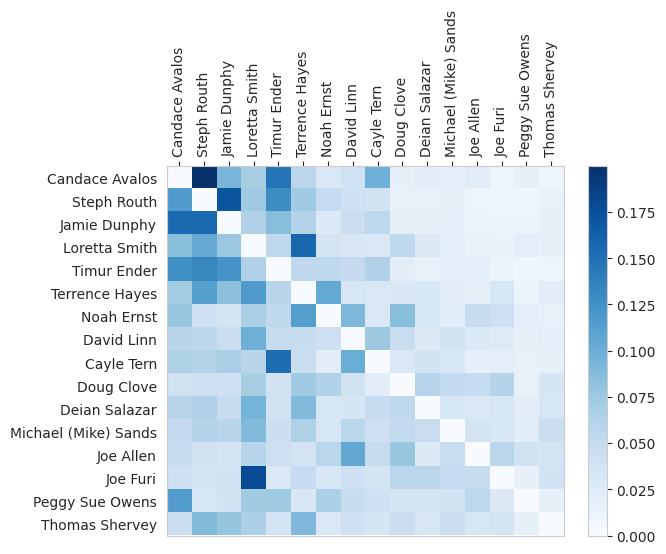

In [4]:
PSM = proportional_successive_matrix(profile)
viz_partition(gen_mentions_partition(profile, candidates, 1), PSM, candidates, cmap='Blues')

## Scores.

The "src/scores.py" contains several scoring functions for partitions, and linear combinations thereof.

As a general rule, these are scores we want to minimize. The cut_score is large when a partition separates candidates who are often adjacent in ballot rankings. The relative_size_score is high when the slates of the partition have unequal total mentions (this is maybe philosophically questionable).

Notice that these scores exist on different scales: the cut_score is normalized to live in $[0,1]$, whereas the the relative_size_score lives in $[k^{-k}, 100^{k-1}]$.

Below, we see that the mentions_partition has a better cut_score than the random partition.

In [5]:
print(cut_score(profile, converted_partition), relative_size_score(profile, converted_partition)) #note we passed the int8 format here and it was fine
print(cut_score(profile, mentions_partition), relative_size_score(profile, mentions_partition))

0.7080395660593194 25.432942692288137
0.48061696734977666 46.326078415441074


When we use them inside a Markov chains, we use score generators rather than score functions.

These are functions that take some input (e.g. the election profile, or the number of blocks in the partition) and return a scoring function tailor-made to remember that information, so it can compute its score fast.

Unlike the basic score functions above, the functions made by score generators only accept the int8 format for partitions.

In [6]:
fast_cut_score = cut_score_generator(profile)
fast_relative_size_score = relative_size_score_generator(profile, k=3)
print(fast_cut_score(converted_partition), fast_relative_size_score(converted_partition))
#note the below should execute pretty fast:
for _ in range(1000):
    fast_cut_score(converted_partition)
    fast_relative_size_score(converted_partition)

0.7080395660593195 25.432942692288126


## Chains.

The "src/markov.py" contains a proposal to get from one partition to the other, as well as a tilted run and a short burst chain, which can be run to optimize any score you pass to it.

The process to setup a chain is pretty straightforward:
1) Generate a fast score function for the chain to optimize;
2) Pass it to the chain along with a starting partition.

By default, the chain only returns the best proposal it found during the chain, but there are options to tweak the output format.

In [7]:
def my_awesome_score(partition):
    return 100*fast_cut_score(partition) + fast_relative_size_score(partition)
best = fast_tilted_run(converted_partition, my_awesome_score, iterations=1000, beta=3)

Combined score of random partition: 96.23689929822007
Combined score of tilted run partition: 82.86158377475161


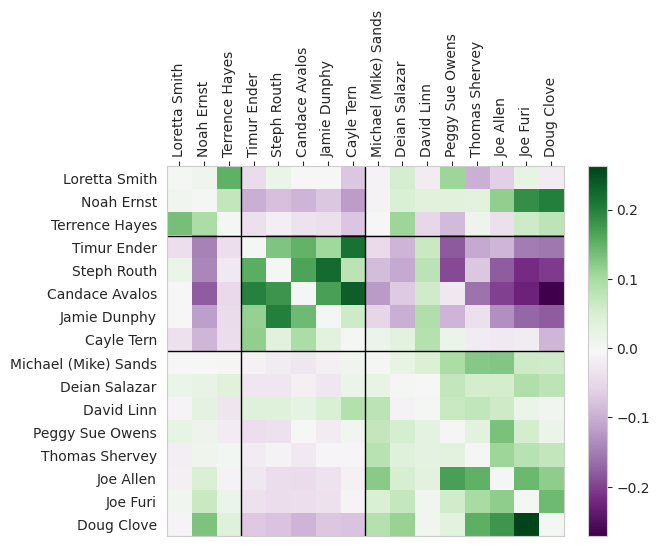

In [8]:
print(f"Combined score of random partition: {my_awesome_score(forward_convert(starting_partition, candidates))}")
print(f"Combined score of tilted run partition: {my_awesome_score(best)}")
viz_partition(best, boost, candidates)

This looks decent, but you might begin to suspect that we would be better off using k=2 slates for this election, rather than 3. Let's try running another tilted run to do this.

Combined score of tilted run partition: 7.033043602529393
Combined score of random partition: 8.10214102941289


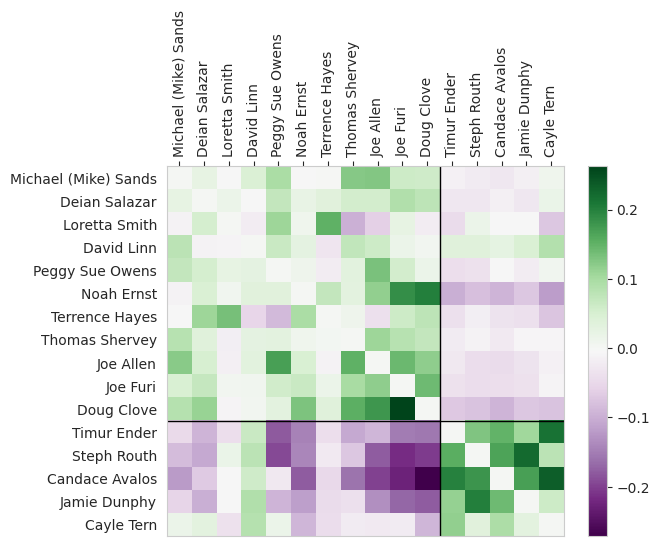

In [11]:
converted_partition = forward_convert(random_partition(candidates, 2), profile.candidates)
fast_relative_size_score2k = relative_size_score_generator(profile, k=2)
def my_awesome_score2k(partition):
    return 8*fast_cut_score(partition) + fast_relative_size_score2k(partition)
best = fast_tilted_run(converted_partition, my_awesome_score2k, iterations=1000, beta = 10)
print(f"Combined score of tilted run partition: {my_awesome_score2k(best)}")
print(f"Combined score of random partition: {my_awesome_score2k(converted_partition)}")
viz_partition(best, boost, candidates)

You may notice that in the above, I manually tweaked the weight on each partition, because cut_score tends to be larger for partitions with more slates (because more candidates get split up). Not only this, but the tilted_run function has a beta parameter which tells it how often to accept worst proposals, which we need to tweak to match new scores. This is a pain to do manually.

Instead, we have a callibrator function that can do this for us! What this does is take a short random walk (1000 steps), look at the range of each score function you pass to it, and re-weight them so they have the same median.

This calibration function returns a scoring function which is weighed to have a median of 100; and the default beta parameter in tilted_run is picked so that a score that is worst by 10 is accepted 1/2 of the time.

In [12]:
super_awesome_score = calibrate_scores([fast_cut_score, fast_relative_size_score2k], converted_partition, print_weights=True)
print(super_awesome_score(converted_partition)) #the "average" partition should score around 100

Weights for score functions (to achieve equal median scores):
Score function 0: 97.08422855815574
Score function 1: 12.410162708280543
99.40346219950933


Let's test this new fancy scoring function on a short burst run:

100%|██████████| 50/50 [00:00<00:00, 244.49it/s]


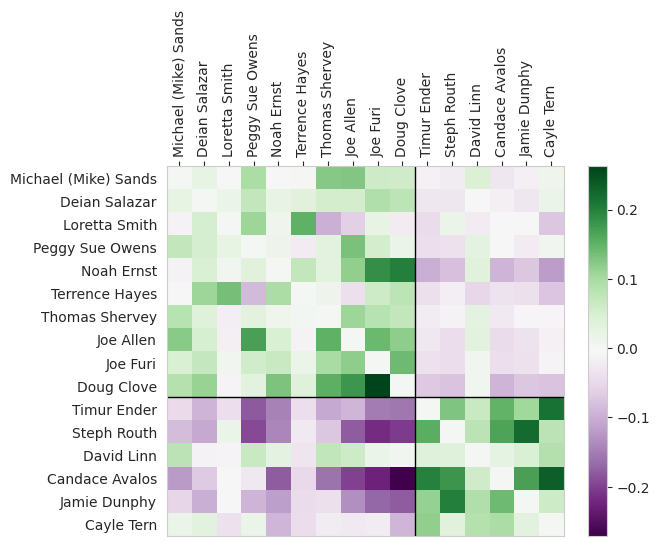

In [ ]:
best_burst = fast_short_burst(converted_partition, super_awesome_score)
viz_partition(best_burst, boost, candidates)

# Louvain Method for Clustering

In [44]:
# this is our old dirty data, includes overvotes and duplicates D: but it gives a slightly different partition...
with open('./data/Portland_D1_og.pkl', 'rb') as file:
    loaded_og = load(file)

Now, we will try a different approach: Louvain method for clustering! Louvain is a greedy algorithm that maximizes modularity (Newman). First, we need to convert our boost matrix intro a graph! The way we are doing this is converting each candidate into a noode and averaging the boost between two candidates. However, due to constraints within the algorithm, if the average sum is negative, then we set that edge to zero.

We provide two methods: create_graph_louvain_bm which converts a boost matrix into a graph, and louvain_partition_from_graph which outputs the best partition found by Louvain and its modularity score.

Notice that Louvain is not deterministic, and so different runs can give different partitions...

In [95]:
# create a graph from boost matrix, HERE I AM USING THE DIRTY BOOST MATRIX, but generating the partition only with
# the 'clean' candidates
G = create_graph_louvain_bm(loaded_og['boost'])
partition_louv, modularity_score = louvain_partition_from_graph(G, profile, 1, True)
partition_louv

[['Loretta Smith',
  'Terrence Hayes',
  'Noah Ernst',
  'Doug Clove',
  'Deian Salazar',
  'Michael (Mike) Sands',
  'Joe Allen',
  'Joe Furi',
  'Peggy Sue Owens',
  'Thomas Shervey'],
 ['Candace Avalos',
  'Steph Routh',
  'Jamie Dunphy',
  'Timur Ender',
  'David Linn',
  'Cayle Tern']]

In [96]:
# generating graph from the clean boost matrix
G_c = create_graph_louvain_bm(boost)
partition_louv_c, modularity_score_c = louvain_partition_from_graph(G_c, profile, 1, True)
partition_louv_c

[['Candace Avalos',
  'Jamie Dunphy',
  'Loretta Smith',
  'Cayle Tern',
  'Doug Clove',
  'Deian Salazar',
  'Michael (Mike) Sands',
  'Joe Allen',
  'Joe Furi',
  'Thomas Shervey'],
 ['Steph Routh',
  'Timur Ender',
  'Terrence Hayes',
  'Noah Ernst',
  'David Linn',
  'Peggy Sue Owens']]

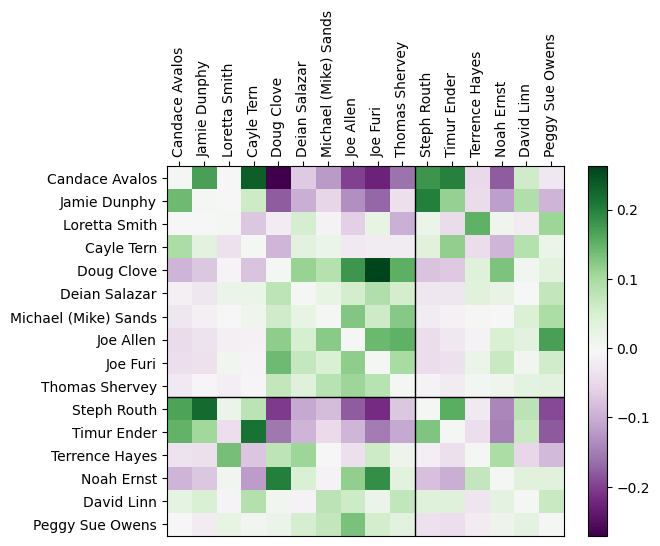

np.float64(0.40678263800953945)

In [97]:
viz_partition(partition_louv_c, boost, candidates)
modularity_score_c

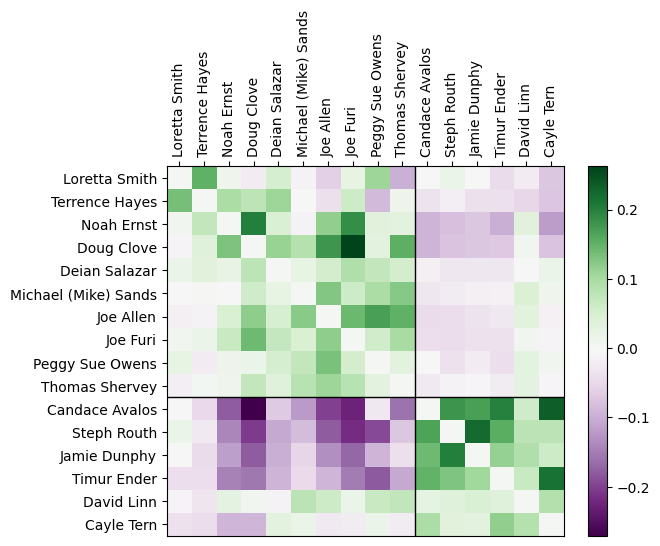

np.float64(0.4024830787288973)

In [98]:
viz_partition(partition_louv, boost, candidates)
modularity_score